# EXTRACCIÓN DE DATOS Y PRETRATAMIENTO

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Los datos han sido extraídos del artículo de [Amaresh Mishra Dr., Markus K. R. Fischer Dipl.-Chem., Peter Bäuerle Prof. Dr.](https://onlinelibrary.wiley.com/doi/full/10.1002/anie.200804709)

In [3]:
url_csv = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vRpQ_-OWXKsrAwqXnWYRhxGIV6fqigu1XLgoJMIdRCH4fdTW8AYtPt0-KkbI2gaiV-ITJH2Gouclfjg/pub?gid=0&single=true&output=csv'
data = pd.read_csv(url_csv)
data.head(10)

,ID,SMILES,J,V,FF,n,Ref
0,1,CN(C)c2ccc(/C(=C\C=C\C=C(C#N)\C(=O)O)c1ccc(N(C...,12.9,0.71,0.74,6.8,"39,41"
1,2,CCN(CC)c2ccc(/C(=C\C=C\C=C(C#N)\C(=O)O)c1ccc(N...,16.4,0.61,0.66,6.6,"39,41"
2,3,CN(C)c3ccc(/C(=C/c1ccc(/C=C(C#N)/C(=O)O)s1)c2c...,12.5,0.68,0.69,5.9,40
3,4,CC2(C)CC[N]1CCC(C)(C)c3c1c2cc4cc(/C=C/C=C(C#N)...,14.0,0.60,0.71,6.0,"42,45"
4,5,CC2(C)CC[N]1CCC(C)(C)c4c1c2cc5cc(/C=C\c3ccc(/C...,14.7,0.67,0.73,7.2,44
5,6,CC2(C)CC[N]1CCC(C)(C)c5c1c2cc6cc(c4ccc(c3ccc(/...,14.3,0.73,0.74,7.7,"37, 44, 46, 47"
6,7,CC2(C)CC[N]1CCC(C)(C)c5c1c2cc6cc(c4ccc(/C=C\c3...,15.9,0.69,0.75,8.2,48
7,8,CC2(C)CC[N]1CCC(C)(C)c5c1c2cc6cc(/C=C(C#N)/c4c...,18.8,0.53,0.65,6.5,49
8,9,CCCCCCc4cc(c3sc(c2sc(c1sc(/C=C(C#N)/C(=O)O)cc1...,14.0,0.74,0.74,7.7,"50,51"
9,10,CCCCCCc1cc(/C=C(C#N)/C(=O)O)sc1c7ccc(c6ccc(c5c...,10.2,0.67,0.64,4.4,51


In [112]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem import RDConfig
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs

In [9]:
# !pip install py3Dmol
import py3Dmol
def show(smi, style='stick'):
    smiles_to_mol = Chem.MolFromSmiles(smi)
    add_hs = Chem.AddHs(smiles_to_mol)
    AllChem.EmbedMolecule(add_hs)
    AllChem.MMFFOptimizeMolecule(add_hs, maxIters=200)
    mblock = Chem.MolToMolBlock(add_hs)

    view = py3Dmol.view(width=300, height=300)
    view.addModel(mblock, 'mol')
    view.setStyle({style:{}})
    view.zoomTo()
    view.show()
    
# example
show(data.SMILES[2])  # or 'P'

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Text(0, 0.5, 'Frequency')

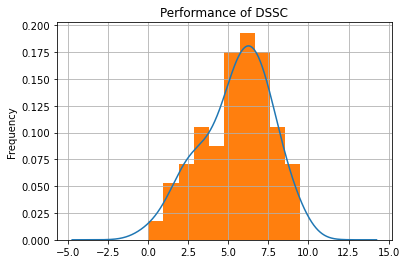

In [86]:
# Analizando la normalidad de los parámetros de rendimiento de celda
# !pip install statsmodels
from turtle import title
from statsmodels.graphics.gofplots import qqplot
from scipy import stats

fig, ax = plt.subplots()
data.n.plot.kde(ax=ax, legend=False, title="Performance of DSSC")
data.n.hist(density=True, ax=ax)
ax.set_ylabel('Frequency')

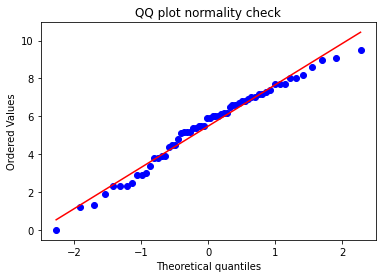

In [88]:
# q-q plot 
res = stats.probplot(data.n, plot=plt)
plt.title('QQ plot normality check')
plt.show()

In [97]:
from array import array
from scipy.stats import shapiro
from scipy.stats import normaltest

columns = ['Name test','Statistics','p','Conclusion']
name_test = []
stat_list = []
p_list = []
conclusion_list = []

name_test.append('shapiro')
stat, p = shapiro(data.n)
stat_list.append(stat)
p_list.append(p)
# interpret
alpha = 0.05
if p > alpha:
	conclusion = 'Sample looks Gaussian (fail to reject H0)'
else:
	conclusion = 'Sample does not look Gaussian (reject H0)'
conclusion_list.append(conclusion)

name_test.append('normaltest')
stat, p = normaltest(data.n)
stat_list.append(stat)
p_list.append(p)
# interpret
alpha = 0.05
if p > alpha:
	conclusion = 'Sample looks Gaussian (fail to reject H0)'
else:
	conclusion = 'Sample does not look Gaussian (reject H0)'
conclusion_list.append(conclusion)

inference_normal_distribution = np.array([name_test, stat_list, p_list, conclusion_list])

In [110]:
df_normal = pd.DataFrame(data=inference_normal_distribution).T
df_normal.columns=columns
df_normal


,Name test,Statistics,p,Conclusion
0,shapiro,0.9745835661888123,0.24299851059913635,Sample looks Gaussian (fail to reject H0)
1,normaltest,2.377853620045508,0.30454792653225504,Sample looks Gaussian (fail to reject H0)


## CONSTRUCCIÓN DE LAS ETIQUETAS

Las etiquetas se crean en función de los rendimientos de los dispositivos
(Ojo: Se asume que el rendimiento de las celdas solares sensibilizadas por tintes depende de la estructura molecular de los tintes)

In [71]:
data['performance'] = np.select([data.n >6.5,(data.n <= 6.5) & (data.n > 4.5),data.n <= 4.5 ],['high','medium','low']) # high, medium, low
data.head(10)

,ID,SMILES,J,V,FF,n,Ref,performance
0,1,CN(C)c2ccc(/C(=C\C=C\C=C(C#N)\C(=O)O)c1ccc(N(C...,12.9,0.71,0.74,6.8,"39,41",high
1,2,CCN(CC)c2ccc(/C(=C\C=C\C=C(C#N)\C(=O)O)c1ccc(N...,16.4,0.61,0.66,6.6,"39,41",high
2,3,CN(C)c3ccc(/C(=C/c1ccc(/C=C(C#N)/C(=O)O)s1)c2c...,12.5,0.68,0.69,5.9,40,medium
3,4,CC2(C)CC[N]1CCC(C)(C)c3c1c2cc4cc(/C=C/C=C(C#N)...,14.0,0.60,0.71,6.0,"42,45",medium
4,5,CC2(C)CC[N]1CCC(C)(C)c4c1c2cc5cc(/C=C\c3ccc(/C...,14.7,0.67,0.73,7.2,44,high
5,6,CC2(C)CC[N]1CCC(C)(C)c5c1c2cc6cc(c4ccc(c3ccc(/...,14.3,0.73,0.74,7.7,"37, 44, 46, 47",high
6,7,CC2(C)CC[N]1CCC(C)(C)c5c1c2cc6cc(c4ccc(/C=C\c3...,15.9,0.69,0.75,8.2,48,high
7,8,CC2(C)CC[N]1CCC(C)(C)c5c1c2cc6cc(/C=C(C#N)/c4c...,18.8,0.53,0.65,6.5,49,medium
8,9,CCCCCCc4cc(c3sc(c2sc(c1sc(/C=C(C#N)/C(=O)O)cc1...,14.0,0.74,0.74,7.7,"50,51",high
9,10,CCCCCCc1cc(/C=C(C#N)/C(=O)O)sc1c7ccc(c6ccc(c5c...,10.2,0.67,0.64,4.4,51,low


Se analiza la distribución de las etiquetas para que sean iguales

Text(0.5, 1.0, 'Histograma de las etiquetas')

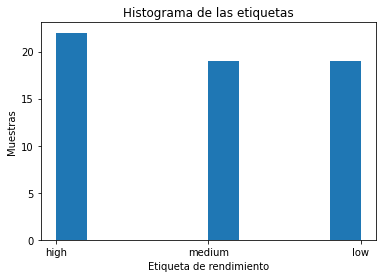

In [92]:
plt.hist(data.performance)
plt.ylabel('Muestras')
plt.xlabel('Etiqueta de rendimiento')
plt.title('Histograma de las etiquetas')

## Creación de descriptores moleculares a partir de los datos SMILES

In [115]:
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors


calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
header = calc.GetDescriptorNames()

rdkit_descriptors = []
for i in range(len(data.SMILES)):
  ds = calc.CalcDescriptors(Chem.MolFromSmiles(data.SMILES[i]))
  rdkit_descriptors.append(ds)
df_descriptors = pd.DataFrame(rdkit_descriptors,columns=header)
df_descriptors.head(10)

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,10.927313,-1.236202,10.927313,0.303822,0.434791,387.483,362.283,387.194677,148,0,...,0,0,0,0,0,0,0,0,0,0
1,11.026406,-1.231171,11.026406,0.297823,0.265940,443.591,410.327,443.257277,172,0,...,0,0,0,0,0,0,0,0,0,0
2,11.135251,-1.221625,11.135251,0.276712,0.387879,443.572,418.372,443.166748,162,0,...,0,0,0,0,0,0,0,1,0,0
3,12.752931,-1.307927,12.752931,0.014141,0.341068,418.493,392.285,418.189257,160,0,...,0,0,0,0,0,0,0,0,0,0
4,13.054169,-1.256982,13.054169,0.035169,0.260914,500.620,472.396,500.176978,184,0,...,0,0,0,0,0,0,0,1,0,0
5,13.410867,-1.246497,13.410867,0.033699,0.159769,556.709,528.485,556.149049,198,0,...,0,0,0,0,0,0,0,2,0,0
6,13.399814,-1.239815,13.399814,0.042299,0.145955,582.747,552.507,582.164699,208,0,...,0,0,0,0,0,0,0,2,0,0
7,13.380942,-1.271711,13.380942,0.013131,0.139625,607.757,578.525,607.159948,216,0,...,0,0,0,0,0,0,0,2,0,0
8,11.903840,-1.174482,11.903840,0.215841,0.031727,955.478,884.918,954.432013,348,0,...,0,0,0,0,0,0,0,4,8,0
9,11.586457,-1.188245,11.586457,0.232582,0.056783,787.154,740.786,786.244213,276,0,...,0,0,0,0,0,0,0,4,4,0


In [116]:
# Se eliminan columnas con único valor
for col in df_descriptors.columns:
    if len(df_descriptors[col].unique()) == 1:
        df_descriptors.drop(col,inplace=True,axis=1)
len(df_descriptors.columns)

143

In [118]:
# Se eliminan columnas con único valor
cor_matrix = df_descriptors.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
X_procesado = df_descriptors.drop(df_descriptors[to_drop].columns, axis=1)
len(X_procesado.columns)

<ipython-input-118-bd00754e8b82>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))


94

In [121]:
# !pip install sklearn
from sklearn.preprocessing import StandardScaler
head=X_procesado.columns
scaler =StandardScaler()
X_procesado = pd.DataFrame(scaler.fit_transform(X_procesado), columns=head) 

In [122]:
X_procesado.head()

,MaxEStateIndex,MinEStateIndex,MinAbsEStateIndex,qed,MolWt,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,BCUT2D_MWHI,BCUT2D_MWLOW,...,fr_allylic_oxid,fr_amide,fr_aryl_methyl,fr_bicyclic,fr_imide,fr_methoxy,fr_para_hydroxylation,fr_sulfide,fr_thiazole,fr_unbrch_alkane
0,-0.996813,-0.347859,1.080121,1.583411,-0.942347,0.025074,-0.081859,0.143078,-2.242341,0.314343,...,3.217470,-0.366871,-0.412121,-0.946552,-0.229416,-0.201153,-0.591153,-0.392232,-0.229416,-0.241559
1,-0.887545,-0.313246,1.031019,0.446459,-0.748455,0.025074,-0.081859,-0.027318,-2.242340,0.305994,...,3.217470,-0.366871,-0.412121,-0.946552,-0.229416,-0.201153,-0.591153,-0.392232,-0.229416,-0.241559
2,-0.767523,-0.247581,0.858230,1.267532,-0.748521,0.028383,-0.081824,0.078339,0.445368,0.304666,...,-0.459639,-0.366871,-0.412121,-0.946552,-0.229416,-0.201153,-0.591153,-0.392232,-0.229416,-0.241559
3,1.016272,-0.841258,-1.290806,0.952331,-0.835186,0.025074,-0.081859,1.713519,-2.237635,-1.358743,...,1.378916,-0.366871,-0.412121,-0.184228,-0.229416,-0.201153,-0.591153,-0.392232,-0.229416,-0.241559
4,1.348443,-0.490806,-1.118695,0.412616,-0.551381,0.028383,-0.081824,1.359759,0.445368,-1.358741,...,-0.459639,-0.366871,-0.412121,-0.184228,-0.229416,-0.201153,-0.591153,-0.392232,-0.229416,-0.241559


In [123]:
dataset = pd.concat([X_procesado, data.performance], axis=1)
dataset.head()

,MaxEStateIndex,MinEStateIndex,MinAbsEStateIndex,qed,MolWt,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,BCUT2D_MWHI,BCUT2D_MWLOW,...,fr_amide,fr_aryl_methyl,fr_bicyclic,fr_imide,fr_methoxy,fr_para_hydroxylation,fr_sulfide,fr_thiazole,fr_unbrch_alkane,performance
0,-0.996813,-0.347859,1.080121,1.583411,-0.942347,0.025074,-0.081859,0.143078,-2.242341,0.314343,...,-0.366871,-0.412121,-0.946552,-0.229416,-0.201153,-0.591153,-0.392232,-0.229416,-0.241559,high
1,-0.887545,-0.313246,1.031019,0.446459,-0.748455,0.025074,-0.081859,-0.027318,-2.242340,0.305994,...,-0.366871,-0.412121,-0.946552,-0.229416,-0.201153,-0.591153,-0.392232,-0.229416,-0.241559,high
2,-0.767523,-0.247581,0.858230,1.267532,-0.748521,0.028383,-0.081824,0.078339,0.445368,0.304666,...,-0.366871,-0.412121,-0.946552,-0.229416,-0.201153,-0.591153,-0.392232,-0.229416,-0.241559,medium
3,1.016272,-0.841258,-1.290806,0.952331,-0.835186,0.025074,-0.081859,1.713519,-2.237635,-1.358743,...,-0.366871,-0.412121,-0.184228,-0.229416,-0.201153,-0.591153,-0.392232,-0.229416,-0.241559,medium
4,1.348443,-0.490806,-1.118695,0.412616,-0.551381,0.028383,-0.081824,1.359759,0.445368,-1.358741,...,-0.366871,-0.412121,-0.184228,-0.229416,-0.201153,-0.591153,-0.392232,-0.229416,-0.241559,high


In [124]:
# Se crean valores dummy
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
data_ml = dataset.values
X = data_ml[:,0:94].astype(float)
Y = data_ml[:,94]

encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
encoded_Y

array([0, 0, 2, 2, 0, 0, 0, 2, 0, 1, 1, 1, 1, 2, 0, 0, 2, 0, 0, 2, 0, 1,
       2, 1, 1, 0, 2, 1, 1, 1, 2, 0, 0, 2, 0, 2, 0, 0, 1, 1, 1, 1, 2, 1,
       2, 1, 2, 0, 2, 0, 2, 2, 0, 2, 1, 2, 1, 1, 0, 0])

In [127]:
# !pip install tensorflow

from tensorflow.keras.utils import to_categorical
dummy_y = to_categorical(encoded_Y)
dummy_y

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0

In [128]:
def baseline_model():
	# create model
	model = Sequential()
	model.add(Dense(8, input_dim=94, activation='relu'))
	model.add(Dense(3, activation='softmax'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

In [130]:
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.python.util.tf_export import keras_export
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

estimator1 = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=5, verbose=0)
kfold = KFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator1, X, dummy_y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

<ipython-input-130-51ad57ec84dc>:8: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator1 = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=5, verbose=0)


Baseline: 48.33% (24.09%)


In [131]:
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 48.33% (24.09%)


In [132]:
def modified1_model():
	# create model
	model = Sequential()
	model.add(Dense(30, input_dim=94, activation='relu'))
	model.add(Dense(3, activation='softmax'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

In [133]:
estimator2 = KerasClassifier(build_fn=modified1_model, epochs=200, batch_size=5, verbose=0)
kfold = KFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator2, X, dummy_y, cv=kfold)
print("Modified 1: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

<ipython-input-133-5e9272bcde6c>:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator2 = KerasClassifier(build_fn=modified1_model, epochs=200, batch_size=5, verbose=0)


Modified 1: 46.67% (23.33%)


In [134]:
def modified2_model():
	# create model
	model = Sequential()
	model.add(Dense(30, input_dim=94, activation='relu'))
	model.add(Dense(3, activation='sigmoid'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

In [135]:
estimator3 = KerasClassifier(build_fn=modified2_model, epochs=200, batch_size=5, verbose=0)
kfold = KFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator3, X, dummy_y, cv=kfold)
print("Modified 2: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

<ipython-input-135-c65a3fac7d2a>:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator3 = KerasClassifier(build_fn=modified2_model, epochs=200, batch_size=5, verbose=0)


Modified 2: 48.33% (28.33%)


In [136]:
results

array([0.33333334, 0.5       , 0.33333334, 0.83333331, 0.66666669,
       0.83333331, 0.16666667, 0.83333331, 0.33333334, 0.        ])